# Part two

## Preparation

In [1]:
import unidecode
import string
import random
import re

all_characters = string.printable
n_characters = len(all_characters)

file = unidecode.unidecode(open('music/nottingham_abc.txt').read())
file_len = len(file)
print('file_len =', file_len)

file_len = 448659


To make inputs out of this big string of data, we will be splitting it into chunks.

In [2]:
chunk_len = 200

def random_chunk():
    start_index = random.randint(0, file_len - chunk_len)
    end_index = start_index + chunk_len + 1
    return file[start_index:end_index]

print(random_chunk())

hn Jones, via EF
M:6/8
K:D
P:A
A|"D"d3 fed|"A7"cea age|"D"d3 fed|"Em"cdB "A7"ABc|
"D""Bm"d3 fed|"A"cea abg|"Em"fed "A7"cBc|"D"dAF D2:|
P:B
A/2G/2|"D"FFF FAF|"G"GGG GBG|"D"AAA fed|"A7"cea ade|
"D"fed "A


## Build the Model

This model will take as input the character for step $t_{-1}$ and is expected to output the next character $t$. There are three layers - one linear layer that encodes the input character into an internal state, one GRU layer (which may itself have multiple layers) that operates on that internal state and a hidden state, and a decoder layer that outputs the probability distribution.

In [3]:
import torch
import torch.nn as nn
from torch.autograd import Variable

class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, n_layers=1):
        super(RNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.n_layers = n_layers
        
        self.encoder = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size, n_layers)
        self.decoder = nn.Linear(hidden_size, output_size)
    
    def forward(self, input, hidden):
        input = self.encoder(input.view(1, -1))
        output, hidden = self.gru(input.view(1, 1, -1), hidden)
        output = self.decoder(output.view(1, -1))
        return output, hidden

    def init_hidden(self):
        return Variable(torch.zeros(self.n_layers, 1, self.hidden_size))

## Inputs and Targets

Each chunk will be turned into a tensor, specifically a `LongTensor` (used for integer values), by looping through the characters of the string and looking up the index of each character in `all_characters`.

In [4]:
# Turn string into list of longs
def char_tensor(string):
    tensor = torch.zeros(len(string)).long()
    for c in range(len(string)):
        tensor[c] = all_characters.index(string[c])
    return Variable(tensor)

print(char_tensor('abcDEF'))

tensor([10, 11, 12, 39, 40, 41])


Finally we can assemble a pair of input and target tensors for training, from a random chunk. The input will be all characters *up to the last*, and the target will be all characters *from the first*. So if our chunk is "abc" the input will correspond to "ab" while the target is "bc".

In [5]:
def random_training_set():    
    chunk = random_chunk()
    inp = char_tensor(chunk[:-1])
    target = char_tensor(chunk[1:])
    return inp, target

## Evaluating

To evaluate the network we will feed one character at a time, use the outputs of the network as a probability distribution for the next character, and repeat. To start generation we pass a priming string to start building up the hidden state, from which we then generate one character at a time.

In [6]:
def evaluate(prime_str='A', predict_len=100, temperature=0.8):
    hidden = decoder.init_hidden()
    prime_input = char_tensor(prime_str)
    predicted = prime_str

    # Use priming string to "build up" hidden state
    for p in range(len(prime_str) - 1):
        _, hidden = decoder(prime_input[p], hidden)
    inp = prime_input[-1]
    probs = []

    for p in range(predict_len):
        output, hidden = decoder(inp, hidden)
        
        # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        norm_dist = output_dist/torch.sum(output_dist)
        prob, top_i = norm_dist.max(0)
#         top_i = torch.multinomial(norm_dist, 1)[0]
        # Add predicted character to string and use as next input
        predicted_char = all_characters[top_i]
#         probs.append(norm_dist[top_i].item())
        probs.append(prob)
        predicted += predicted_char
        inp = char_tensor(predicted_char)
    probs = torch.FloatTensor(probs)

    perplexity = (-1 * torch.sum(torch.log(probs))/predict_len)
    return predicted,perplexity.item()

In [7]:
def evaluate_all(inputStr,temperature=0.8):
    eval_len = len(inputStr)
    hidden = decoder.init_hidden()
    prime_input = char_tensor(' ')
    probs = []
    # using ' 'space as the priming input for validation
    _, hidden = decoder(prime_input[0], hidden)
    inp = prime_input[-1]
    
    for p in range(0,eval_len):
        temp = char_tensor(inputStr[p]) # index for expected char
        output, hidden = decoder(inp, hidden)
         # Sample from the network as a multinomial distribution
        output_dist = output.data.view(-1).div(temperature).exp()
        norm_dist = output_dist/torch.sum(output_dist)
        # retrieve the probability from norm_dist according to input char
        prob = norm_dist[temp]
        probs.append(prob)
        inp = temp
    probs = torch.FloatTensor(probs)
    
    perplexity = (-1 * torch.sum(torch.log(probs))/eval_len)
    return perplexity.item()

## Training

A helper to print the amount of time passed:

In [8]:
import time, math

def time_since(since):
    s = time.time() - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

The main training function

In [9]:
def train(inp, target):
    hidden = decoder.init_hidden()
    decoder.zero_grad()
    loss = 0

    for c in range(chunk_len):
        output, hidden = decoder(inp[c], hidden)
        loss += criterion(output, target[c].unsqueeze(0))

    loss.backward()
    decoder_optimizer.step()

    return loss.data.item() / chunk_len

Then we define the training parameters, instantiate the model, and start training:

In [10]:
n_epochs = 10000
print_every = 1000
plot_every = 10
hidden_size = 100
n_layers = 1
lr = 0.005

decoder = RNN(n_characters, hidden_size, n_characters, n_layers)
decoder_optimizer = torch.optim.Adam(decoder.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

start = time.time()
all_losses = []
loss_avg = 0

for epoch in range(1, n_epochs + 1):
    loss = train(*random_training_set())       
    loss_avg += loss

    if epoch % print_every == 0:
        print('[%s (%d %d%%) %.4f]' % (time_since(start), epoch, epoch / n_epochs * 100, loss))
        print(evaluate('T:', 100), '\n')

    if epoch % plot_every == 0:
        all_losses.append(loss_avg / plot_every)
        loss_avg = 0

 17s (1000 10%) 1.8696]
('T:Aly Missin\n% Nottingham Music Database\nS:Trad, arr Phil Rowe\nM:6/8\nK:G\nP:A\nB/2|"G"GG "G"GG/2G/2|"G"G', 0.3169077932834625) 

 35s (2000 20%) 1.3052]
('T:Lay Annine the of the of the of the Ball Bonpipe\n% Nottingham Music Database\nS:The Dar Phil Rowe\nM:6', 0.5471680760383606) 

 43s (3000 30%) 1.1130]
('T:Arest 1985, via EF\nM:4/4\nL:1/4\nK:D\n"D"AF "A7"AB|"A"A2 A2|"D"d2 d2:|\n\n\nX: 11\nT:The Eerst Woane\n% Nott', 0.44136670231819153) 

 50s (4000 40%) 1.5028]
('T:Bol Bord Warrs o the Roueary\n% Nottingham Music Database\nS:Trad, arr Phil Rowe\nM:6/8\nK:D\nP:A\nA|"D"d2', 0.3879016637802124) 

 51s (5000 50%) 0.6011]
('T:Birs Jig\n% Nottingham Music Database\nS:Kevin Briggs, via EF\nM:4/4\nL:1/4\nK:G\nP:A\nd/2c/2|"G"BG/2A/2 B/', 0.20732757449150085) 

 3s (6000 60%) 0.8688]
('T:Botttting\nM:4/4\nL:1/4\nK:G\nP:A\nA/2B/2|"D"d/2d/2d/2d/2 "A7"c/2d/2c/2B/2|"D"A/2B/2A/2G/2 "A7"A/2G/2A/2B', 0.3463558852672577) 

 18s (7000 70%) 1.1900]
('T:Bob Quille\n% Not

## Plotting the Training Losses

Plotting the historical loss from all_losses shows the network learning:

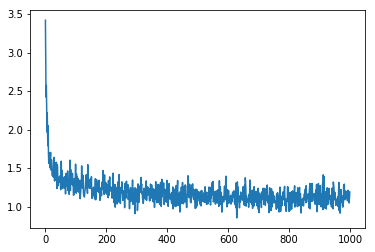

In [11]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
%matplotlib inline

plt.figure()
plt.plot(all_losses)

## Evaluating at different "temperatures"

In the `evaluate` function above, every time a prediction is made the outputs are divided by the "temperature" argument passed. Using a higher number makes all actions more equally likely, and thus gives us "more random" outputs. Using a lower value (less than 1) makes high probabilities contribute more. As we turn the temperature towards zero we are choosing only the most likely outputs.

We can see the effects of this by adjusting the `temperature` argument.

In [12]:
print(evaluate('T:', 50, temperature=0.4))

('T:Brand Wolling Camillle\n% Nottingham Music Database', 0.19479234516620636)


Lower temperatures are less varied, choosing only the more probable outputs:

In [13]:
print(evaluate('T:', 200, temperature=0.9))

('T:Brand Wolling Camillle\n% Nottingham Music Database\nS:Trad, via EF\nM:4/4\nL:1/4\nK:D\n"D"A2 f2|"A"e2 a2|"A"e2 "D"d2|"A"e2 "A7"e2|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"', 0.4391261041164398)


Higher temperatures more varied, choosing less probable outputs:

In [14]:
print(evaluate('T:', 300, temperature=0.95))

('T:Brand Wolling Camillle\n% Nottingham Music Database\nS:Trad, via EF\nM:4/4\nL:1/4\nK:D\n"D"A2 f2|"A"e2 a2|"A"e2 "D"d2|"A"e2 "A7"e2|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 "A7"ed|"D"d2 ', 0.47386056184768677)


## Comparision

In [16]:
xmas = unidecode.unidecode(open('music/xmas.txt').read())
sample_x = xmas[0:200]

In [17]:
sample_x

'\nX: 1\nT:The Boar\'s Head\n% Nottingham Music Database\n%P:AAB\nS:Vic\nM:4/4\nL:1/4\nK:C\n|:G|"C"c2 cc|"G"Bc "C"G3/2E/2|"F"FF "Dm"AF| [1"G"GA/2B/2 "C"c:| [2"G"GA/2B/2 "C"c2|\n"C"ee "G"dd|"Am"AA "Em"G3/2E/2|"F"F'

In [18]:
evaluate_all(sample_x)

1.2562830448150635

In [19]:
reels_ab = unidecode.unidecode(open('music/all-abcs.txt').read())
sample_ab = reels_ab[0:200]
print(sample_ab)

T:Mr Preston's Hornpipe, 2nd setting
M:3/2
L:1/8
K:C
P:1
c4 B4 A4 | A2 e4 A2 BcdB |\
c4 B4 A4 | G2 c4 A2 BcdB ||
P:2
e2 g4    B2 A4 | A2 a4 A2 BcdB |\
d2 g2 B2 g2 A4 | G2 c4 A2 BcdB ||
P:3
cdec BcdB A


In [20]:
evaluate_all(sample_ab)

4.130214214324951

In [22]:
playford = unidecode.unidecode(open('music/playford.txt').read())
sample_pf = playford[0:200]
print(sample_pf)


X: 1
T:The Alderman's Hat
% Nottingham Music Database
S:Playford
M:4/4
L:1/4
K:Gm
P:A
D|"Gm"GB2G|"D7"^Fd2D|"Gm"GB2G|"D7"^FA2D|"Gm"GB2G|"D"^Fg -"Cm"gc|\
"Gm/d"B2 "D7"A2|"Gm"G3:|
P:B
d|"Gm"dg2d|"Gm"gb2


In [23]:
evaluate_all(sample_pf)

1.3773971796035767